In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matlab.engine
import mne
mne.cuda.init_cuda(verbose=True)
from mne.time_frequency import tfr_multitaper
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelBinarizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.svm import SVC
import tensorflow as tf
import tensorflow_probability as tfp
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import layers, losses
import seaborn as sns
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
filepath = os.getcwd()



ModuleNotFoundError: No module named 'matlab.engine'; 'matlab' is not a package

## Preprocessing

### Load dataset
Load data using a matlab engine, this is the most reliable way to import .mat files to a python environment. <br>
Filtering, epoching and other pre-processing steps are done in MNE.

#### Dataset description
The dataset is taken from this competition (https://www.frontiersin.org/articles/10.3389/fnins.2012.00055/full) and a description of this particular dataset can be found here (https://lampx.tugraz.at/~bci/database/001-2014/description.pdf) <br>
There are 9 participants are included with 22 EEG channels and 3 EoG channels. They are instructed to complete a 4-class motor imagery task (Left hand, Right hand, Feet, and Tongue) with 4 second trials. Signals are recorded at 250 Hz and bandpass filtered between 0.5 Hz and 100 Hz with a line noise notch filter at 50 Hz. Each participant completes 6 runs of 12 trials each class in 2 separate sessions.

In [ ]:
# Start matlab engine
eng = matlab.engine.start_matlab()

In [ ]:
# Loop through dataset
all_raw = []
ch_names = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
            'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'Oz', 'EoG1', 'EoG2', 'EoG3']
with os.scandir(os.getcwd()+'\\Dataset') as entries:
    for entry in tqdm(entries, total=len(os.listdir(os.getcwd()+'\\Dataset'))):
        this_participant = eng.load(entry.path)
        for trial in this_participant['data']:
            # Create MNE raw object for each recording
            # check that this trial is not an 'EoG' trial (trigs empty)
            if len(np.asarray(trial['trial'])) != 0:
                # Extract .mat variables as np array variablesa
                EEG_data = np.asarray(trial['X']).T
                TrigSample = np.asarray(trial['trial']).squeeze()
                TrigLabels = np.asarray(trial['y'])
                TrigNames = np.asarray(trial['classes'])
                srate = trial['fs']
                # Format into an MNE raw object
                EEG_info = mne.create_info(ch_names=ch_names, ch_types=['eeg']*22+['eog']*3, sfreq=srate)
                EEG_raw = mne.io.RawArray(EEG_data, EEG_info, verbose=False)
                # add anotations to raw
                TrigDescription = [TrigNames[int(x-1)] for x in TrigLabels]
                annotations = mne.Annotations(onset=TrigSample/srate, duration=0, description=TrigDescription)
                EEG_raw.set_annotations(annotations)
                all_raw.append(EEG_raw)


100%|██████████| 18/18 [00:32<00:00,  1.81s/it]


### Filter and Epoch data

Using MNE functions <br>We preprocess the data in the same way for both the Machine Learning classification and the Deep Learning classification. <br>The preprocessing steps from (Matolli et el.) are loosely followed to replicate similar results from the Convolutional Neural Network.

In [ ]:
all_epochs = []
for raw in tqdm(all_raw, total=len(all_raw)):
    # Drop EoG (for now, maybe use for artifact removal later)
    raw = raw.copy().pick_types(eeg=True, eog=False)
    # Bandpass filter here
    raw.filter(2, 70, verbose=False)
    # CAR filter
    raw.set_eeg_reference(verbose=False)
    # # Laplacian filter
    # raw = mne.preprocessing.compute_current_source_density(raw)
    # Resample data
    raw.resample(160)
    # Epoch data
    events, event_id = mne.events_from_annotations(raw, verbose=False)
    these_epochs = mne.Epochs(raw, events=events, event_id=event_id,
                              tmin=-1, tmax=5, baseline=(-1, 0), preload=True, verbose=False)
    all_epochs.append(these_epochs.set_annotations(None))
# Concatenate epochs
# Don't separate by participant, just take all epochs as one
Epochs = mne.concatenate_epochs(all_epochs, verbose=False)
# Inspect Epochs
Epochs


100%|██████████| 108/108 [00:52<00:00,  2.07it/s]


Number of events,5184
Events,feet: 1296left hand: 1296right hand: 1296tongue: 1296
Time range,-1.000 – 5.000 sec
Baseline,-1.000 – 0.000 sec


In [ ]:
print(Epochs.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG
 custom_ref_applied: True
 highpass: 2.0 Hz
 lowpass: 70.0 Hz
 meas_date: unspecified
 nchan: 22
 projs: []
 sfreq: 160.0 Hz
>


## Machine Learning

### Feature extraction

We mainly look at spectral features, as they are the most discriminating when it comes to Motor Imagery classification, we get a time-frequency representation and take the sum of the power from the frequency bins as well as the relative power (sum of frequency bin power / sum of all power)<br>Features include spectral power from the frequency bands Alpha: 8-13 Hz, Low Beta: 13-20 Hz, High Beta: 20-30 Hz, Low Gamma: 30-40 Hz

In [ ]:
# Initialize freqs for time frequency maps and bins for features
freqs = np.arange(2, 45)  # frequencies from 2-45Hz
freq_bins = {'alpha': [8, 13], 'low beta': [13, 20],
             'high beta': [20, 30], 'low gamma': [30, 40]}
# Creating labels for feature columns
feat_names = []
for ch in Epochs.ch_names:
    feats_ch = [ch + ' ' + s for s in list(freq_bins.keys())]
    [feat_names.append(x) for x in feats_ch]
# Initialize the feature dataframe
feats_df = pd.DataFrame(columns=feat_names+['label'])
# Initialize the single obvervation feature dataframe
this_sample_feats = pd.Series(index=feat_names+['label'], dtype='object')
# Loop through each MI class
for MIclass in Epochs.event_id:
    print("Extracting features from " + MIclass + " MI epochs")
    # Use tdqm for progress bar
    for epoch in tqdm(Epochs[MIclass].iter_evoked(), total=len(Epochs[MIclass])):
        # Get time-frequency representation
        epoch_tfr = tfr_multitaper(
            epoch, freqs, n_cycles=freqs/2, return_itc=False, verbose=False)
        epoch_tfr.apply_baseline(
            (-1, 0), mode="percent", verbose=False).crop(0, 4)
        epoch_tfr_df = epoch_tfr.to_data_frame()
        # Add label to this observation feature series
        this_sample_feats['label'] = Epochs.event_id[MIclass]
        # Loop through each frequency band
        for f_bin, f_name in zip(freq_bins.values(), list(freq_bins.keys())):
            this_band_df = epoch_tfr_df[epoch_tfr_df['freq'].between(
                f_bin[0], f_bin[1])]
            # Loop through each channel
            for ch in this_band_df.columns[2:]:
                this_band_ch = this_band_df[ch]
                all_bands_ch = epoch_tfr_df[ch]
                this_feat_name = ch + ' ' + f_name
                this_feat_value = this_band_ch.sum()
                # Add features to this observation series
                this_sample_feats[this_feat_name] = this_feat_value
        # Append this observation to the full feature matrix
        feats_df = feats_df.append(this_sample_feats, ignore_index=True)


Extracting features from feet MI epochs


100%|██████████| 1296/1296 [09:03<00:00,  2.38it/s]


Extracting features from left hand MI epochs


100%|██████████| 1296/1296 [10:49<00:00,  1.99it/s]


Extracting features from right hand MI epochs


100%|██████████| 1296/1296 [10:33<00:00,  2.05it/s]


Extracting features from tongue MI epochs


100%|██████████| 1296/1296 [10:32<00:00,  2.05it/s]


### Training

In [ ]:
# Split to train, test, and validation data (80,10,10)
X_train, X_test_val, y_train, y_test_val = train_test_split(feats_df.copy().drop(
    columns=['label']), feats_df['label'], stratify=feats_df['label'], test_size=0.20, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, stratify=y_test_val, test_size=0.50, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape,
      y_test.shape, X_val.shape, y_val.shape)


(4147, 88) (4147,) (518, 88) (518,) (519, 88) (519,)


Using a Support Vector Machine and the gridsearch function from sci-kit learn, we get the best values for the SVM hyperparameters (C and kernal type)

Linear kernel takes a long time to train, I think convergence takes too long because the data is not linearly separable
<br>Test some non-linear kernals instead

In [ ]:
search = make_pipeline(RobustScaler(), GridSearchCV(SVC(), param_grid={
                       'kernel': ('poly', 'rbf', 'sigmoid'), 'C': np.arange(1, 10)}, scoring='accuracy', verbose=1))
search.fit(X_train, y_train.astype(int))


Fitting 5 folds for each of 27 candidates, totalling 135 fits


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('gridsearchcv',
                 GridSearchCV(estimator=SVC(),
                              param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                          'kernel': ('poly', 'rbf', 'sigmoid')},
                              scoring='accuracy', verbose=1))])

In [ ]:
search[1].best_params_

{'C': 1, 'kernel': 'rbf'}

### Classification


 Classification report 

               precision    recall  f1-score   support

        feet       0.26      0.21      0.24       259
   left hand       0.29      0.33      0.31       259
  right hand       0.35      0.36      0.36       260
      tongue       0.31      0.33      0.32       259

    accuracy                           0.31      1037
   macro avg       0.31      0.31      0.31      1037
weighted avg       0.31      0.31      0.31      1037


 Confusion matrix 

 [[55 65 55 84]
 [54 86 63 56]
 [47 73 94 46]
 [52 69 53 85]]


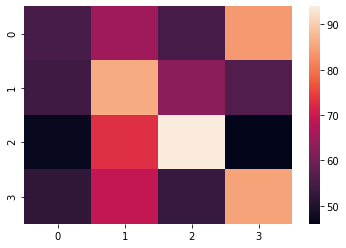

In [ ]:
pipe = Pipeline([('scaler', RobustScaler()), ('svc', SVC(C=1, kernel='rbf'))])
pipe.fit(X_train, y_train.astype(int))
y_pred = pipe.predict(X_test_val)

print('\n Classification report \n\n',
      classification_report(
          y_test_val.astype(int),
          y_pred,
          target_names=Epochs.event_id
      )
      )

print('\n Confusion matrix \n\n',
      confusion_matrix(
          y_test_val.astype(int),
          y_pred,
      )
      )

sns.heatmap(confusion_matrix(
    y_test_val.astype(int),
    y_pred
))


## Deep Learning

Change labels to one-hot encoding for NN

In [ ]:
lb = LabelBinarizer().fit([1, 2, 3, 4])

y_test_OH = lb.transform(y_test.astype(int))
y_val_OH = lb.transform(y_val.astype(int))
y_train_OH = lb.transform(y_train.astype(int))


### Preprocess for raw channel pairs

Just using a few pairs of electrodes ner the motor cortex for now.

In [ ]:
# Initialize pairs for NN training
pairs = [['C1', 'C2'],['C3', 'C4']]
nn_data_list = []
nn_labels = []
# Loop through each MI class
for MIclass in Epochs.event_id:
    # loop through pairs
    for pair in pairs:
        nn_data_list.append(Epochs[MIclass].copy().crop(0,4).pick(pair).get_data()[:,:,:-1])
        for x in range(len(Epochs[MIclass])):
            nn_labels.append(Epochs.event_id[MIclass])
# Change to one-hot encoding
nn_labels_OH = lb.transform(nn_labels)
nn_data = np.concatenate(nn_data_list, axis=0)
nn_data = np.transpose(nn_data, axes=[0,2,1])
print(nn_data.shape, nn_labels_OH.shape)


(10368, 640, 2) (10368, 4)


Split to train, test and validation

In [ ]:
# Split to train, test, and validation data (80,10,10)
X_train_nn, X_test_val_nn, y_train_nn, y_test_val_nn = train_test_split(nn_data, nn_labels_OH, stratify=nn_labels_OH, test_size=0.20, random_state=42)
X_test_nn, X_val_nn, y_test_nn, y_val_nn = train_test_split(
    X_test_val_nn, y_test_val_nn, stratify=y_test_val_nn, test_size=0.50, random_state=42)
print(X_train_nn.shape, y_train_nn.shape, X_test_nn.shape,
      y_test_nn.shape, X_val_nn.shape, y_val_nn.shape)

(8294, 640, 2) (8294, 4) (1037, 640, 2) (1037, 4) (1037, 640, 2) (1037, 4)


### Convolutional Neural Network

In [ ]:
class HopefullNet(tf.keras.Model):
    """
    Original HopeFullNet
    """

    def __init__(self, inp_shape=(640, 2)):
        super(HopefullNet, self).__init__()
        self.inp_shape = inp_shape

        self.kernel_size_0 = 20
        self.kernel_size_1 = 6
        self.drop_rate = 0.5

        self.conv1 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding="same",
                                            input_shape=self.inp_shape)
        self.batch_n_1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_0,
                                            activation='relu',
                                            padding="valid")
        self.batch_n_2 = tf.keras.layers.BatchNormalization()
        self.spatial_drop_1 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.conv3 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding="valid")
        self.avg_pool1 = tf.keras.layers.AvgPool1D(pool_size=2)
        self.conv4 = tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=self.kernel_size_1,
                                            activation='relu',
                                            padding="valid")
        self.spatial_drop_2 = tf.keras.layers.SpatialDropout1D(self.drop_rate)
        self.flat = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(296, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(self.drop_rate)
        self.dense2 = tf.keras.layers.Dense(148, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(self.drop_rate)
        self.dense3 = tf.keras.layers.Dense(74, activation='relu')
        self.dropout3 = tf.keras.layers.Dropout(self.drop_rate)
        self.out = tf.keras.layers.Dense(4, activation='softmax')

    def call(self, input_tensor):
        conv1 = self.conv1(input_tensor)
        batch_n_1 = self.batch_n_1(conv1)
        conv2 = self.conv2(batch_n_1)
        batch_n_2 = self.batch_n_2(conv2)
        spatial_drop_1 = self.spatial_drop_1(batch_n_2)
        conv3 = self.conv3(spatial_drop_1)
        avg_pool1 = self.avg_pool1(conv3)
        conv4 = self.conv4(avg_pool1)
        spatial_drop_2 = self.spatial_drop_2(conv4)
        flat = self.flat(spatial_drop_2)
        dense1 = self.dense1(flat)
        dropout1 = self.dropout1(dense1)
        dense2 = self.dense2(dropout1)
        dropout2 = self.dropout2(dense2)
        return self.out(dropout2)


In [ ]:
learning_rate = 1e-4

loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_CNN = HopefullNet()

model_CNN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# Where to save model
modelPath = filepath + r'\Models\CNN.h5'

# build callback list
checkpoint = ModelCheckpoint(  # set model saving checkpoints
    modelPath,  # set path to save model weights
    monitor='val_loss',  # set monitor metrics
    verbose=1,  # set training verbosity
    save_best_only=True,  # set if want to save only best weights
    save_weights_only=True,  # set if you want to save only model weights
    mode='auto',  # set if save min or max in metrics
    save_freq='epoch'  # interval between checkpoints
)

earlystopping = EarlyStopping(
    monitor='val_loss',  # set monitor metrics
    min_delta=0.001,  # set minimum metrics delta
    patience=4,  # number of epochs to stop training
    restore_best_weights=True,  # set if use best weights or last weights
)
callbacksList = [checkpoint, earlystopping]  # build callbacks list


In [ ]:
hist = model_CNN.fit(X_train_nn, y_train_nn, epochs=100, batch_size=10, validation_data=(X_val_nn,y_val_nn),
                shuffle=True, callbacks=callbacksList, verbose=1)

Epoch 1/100
828/830 [============================>.] - ETA: 0s - loss: 1.5028 - accuracy: 0.2469
Epoch 1: val_loss improved from inf to 1.38419, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\DeepLearningProject-redone\Models\CNN.h5
830/830 [==============================] - 16s 17ms/step - loss: 1.5026 - accuracy: 0.2469 - val_loss: 1.3842 - val_accuracy: 0.2710
Epoch 2/100
830/830 [==============================] - ETA: 0s - loss: 1.3965 - accuracy: 0.2614
Epoch 2: val_loss improved from 1.38419 to 1.37122, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\DeepLearningProject-redone\Models\CNN.h5
830/830 [==============================] - 14s 17ms/step - loss: 1.3965 - accuracy: 0.2614 - val_loss: 1.3712 - val_accuracy: 0.2999
Epoch 3/100
830/830 [==============================] - ETA: 0s - loss: 1.3856 - accuracy: 0.2800
Epoch 3: val_loss improved from 1.37122 to 1.36251, saving model to c:\Users\james\OneDrive\GradSchool\Spring 2022\DeepLearningProject-

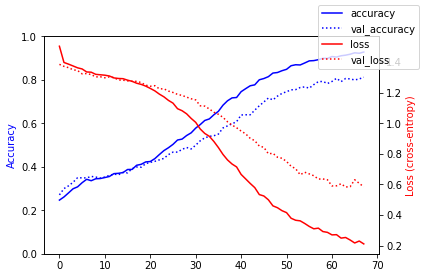

In [ ]:
fig,ax=plt.subplots()
ax.plot(hist.history['accuracy'], color = 'b')
ax.plot(hist.history['val_accuracy'], linestyle=':', color = 'b')
ax.set_ylabel("Accuracy", color = 'b')
ax.set_ylim([0,1])
ax2=ax.twinx()
ax2.plot(hist.history['loss'],  color = 'r')
ax2.plot(hist.history['val_loss'], linestyle=':',  color = 'r')
ax2.set_ylabel("Loss (cross-entropy)",  color = 'r')
fig.legend(['accuracy','val_accuracy','loss','val_loss'])

33/33 [==============================] - 1s 9ms/step

 Cohen kappa 

 0.7274189208792762

 Classification report 

               precision    recall  f1-score   support

        feet       0.77      0.75      0.76       259
   left hand       0.83      0.83      0.83       260
  right hand       0.82      0.80      0.81       259
      tongue       0.77      0.80      0.78       259

    accuracy                           0.80      1037
   macro avg       0.80      0.80      0.80      1037
weighted avg       0.80      0.80      0.80      1037


 Confusion matrix 

 [[195  18  17  29]
 [ 15 215  13  17]
 [ 20  14 208  17]
 [ 23  12  17 207]]


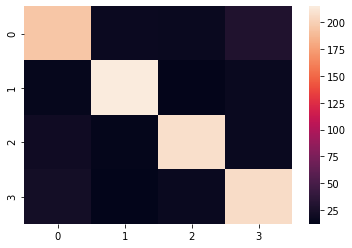

In [ ]:
y_pred = model_CNN.predict(X_test_nn)

# convert from one hot encode in string
yTestClass = np.argmax(y_test_nn, axis=1)
yPredClass = np.argmax(y_pred,axis=1)

print('\n Cohen kappa \n\n',
  cohen_kappa_score(
      yTestClass,
      yPredClass
      )
  )

print('\n Classification report \n\n',
  classification_report(
      yTestClass,
      yPredClass,
       target_names=Epochs.event_id
      )
  )

print('\n Confusion matrix \n\n',
  confusion_matrix(
      yTestClass,
      yPredClass,
      )
  )

sns.heatmap(confusion_matrix(
      yTestClass,
      yPredClass
      ))